In [1]:
!pip install captum
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00


In [2]:
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from tqdm import tqdm
from torchvision import transforms
from torchvision.transforms import v2
from datasets import load_dataset
from transformers import ConvNextV2ForImageClassification
from transformers.models.convnextv2.modeling_convnextv2 import ConvNextV2Embeddings

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
smallnorb = load_dataset("Ramos-Ramos/smallnorb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/24300 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/24300 [00:00<?, ? examples/s]

In [5]:
class SmallNORBDataset(torch.utils.data.Dataset):
  def __init__(self, hf_dataset, subset="train", transform=None):
    self.hf_dataset = hf_dataset
    self.subset = subset
    self.transform = transform

  def __len__(self):
    return len(self.hf_dataset[self.subset])

  def __getitem__(self, idx):
    sample = self.hf_dataset[self.subset][idx]
    image = sample["image_lt"]
    label = sample["category"]

    if self.transform:
      image = self.transform(image)

    return image, label

In [6]:
transforms_test = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229]),
])

In [7]:
test_ds = SmallNORBDataset(smallnorb, "test", transform=transforms_test)

In [8]:
IN_CHANNELS = 1
N_CLASSES = 5

In [9]:
BATCH_SIZE = 1
test_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE)

## VGG-16

In [ ]:
# Load the pre-trained model
IN_CHANNELS = 1
N_CLASSES = 5

vgg16_model = tv.models.vgg16(weights="IMAGENET1K_V1")

for param in vgg16_model.parameters():
    param.requires_grad = False

# 1-channel inputs
vgg16_model.features[0] = nn.Conv2d(IN_CHANNELS, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))

# Add on classifier
n_inputs = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.6),
    nn.Linear(256, N_CLASSES), nn.LogSoftmax(dim=1))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 104MB/s]


In [ ]:
vgg16_model.load_state_dict(torch.load("/content/drive/MyDrive/TTA/vgg16-smallnorb.pt"))

<All keys matched successfully>

In [ ]:
sample = test_ds.__getitem__(429)[0]
print(test_ds.__getitem__(429)[1])
sample = sample.unsqueeze(0)

4


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sample = sample.to(device)

In [ ]:
vgg16_model = vgg16_model.to(device)
vgg16_model.eval()

output = vgg16_model(sample)
print(output)

tensor([[-1.1232e+01, -1.5913e+01, -1.5945e+01, -1.1180e+01, -2.7418e-05]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [ ]:
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
print(prediction_score.squeeze().item(), pred_label_idx.item())

0.9999725818634033 4


In [ ]:
# Create IntegratedGradients object and get attributes
integrated_gradients = IntegratedGradients(vgg16_model)
attributions_ig = integrated_gradients.attribute(sample, target=pred_label_idx.item(), n_steps=30)

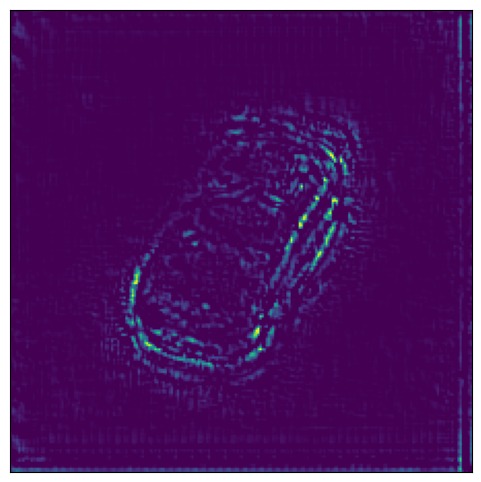

In [ ]:
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)), method="heat_map", sign="positive", cmap="viridis")

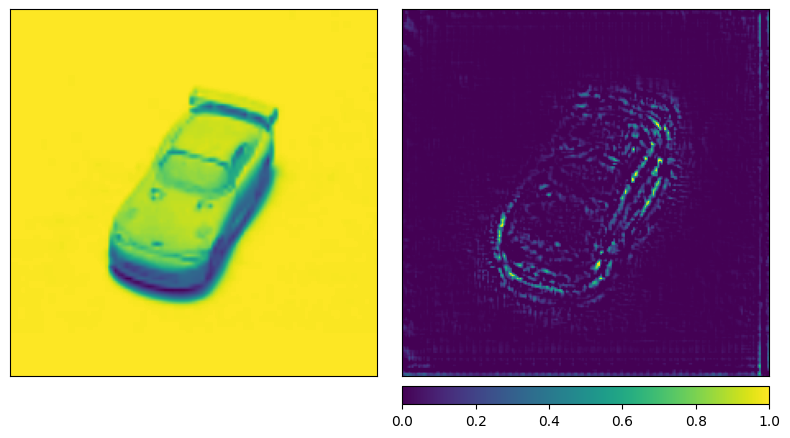

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)),
                             np.transpose(sample.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap="viridis",
                             show_colorbar=True)

(-0.5, 223.5, 223.5, -0.5)

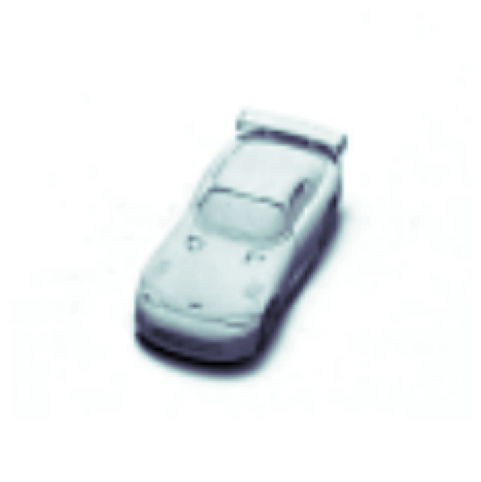

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(sample.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)), cmap="bone")
plt.axis("off")

In [ ]:
from PIL import Image

In [ ]:
img1 = Image.open("/content/drive/MyDrive/TTA/smallnorbVGGimage.png")
img2 = Image.open("/content/drive/MyDrive/TTA/smallnorbVGGfeatures.png")

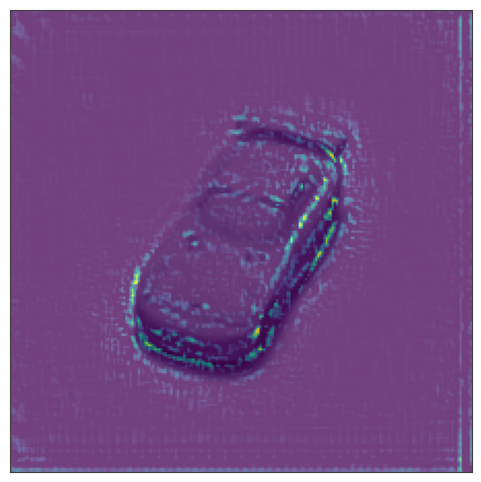

In [ ]:
Image.blend(im1=img1, im2=img2, alpha=0.75)

## ConvNeXt

In [ ]:
IN_CHANNELS = 1
N_CLASSES = 5

convnext_model = tv.models.convnext_base(weights="IMAGENET1K_V1")

for param in convnext_model.parameters():
    param.requires_grad = False

# 1-channel inputs
convnext_model.features[0][0] = nn.Conv2d(IN_CHANNELS, 128, kernel_size=(4,4), stride=(4,4))

# Add on classifier
n_inputs = convnext_model.classifier[2].in_features
convnext_model.classifier[2] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.GELU(), nn.Dropout(0.4),
    nn.Linear(256, N_CLASSES), nn.Softmax(dim=1))

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:02<00:00, 153MB/s]


In [ ]:
convnext_model.load_state_dict(torch.load("/content/drive/MyDrive/TTA/convnext-smallnorb.pt"))

<All keys matched successfully>

In [ ]:
sample = test_ds.__getitem__(429)[0]
print(test_ds.__getitem__(429)[1])
sample = sample.unsqueeze(0)

4


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sample = sample.to(device)

In [ ]:
convnext_model = convnext_model.to(device)
convnext_model.eval()

output = convnext_model(sample)
print(output)

tensor([[8.1382e-05, 9.9595e-07, 5.4079e-07, 2.3054e-04, 9.9969e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [ ]:
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
print(prediction_score.squeeze().item(), pred_label_idx.item())

0.40451526641845703 4


In [ ]:
# Create IntegratedGradients object and get attributes
integrated_gradients = IntegratedGradients(convnext_model)
attributions_ig = integrated_gradients.attribute(sample, target=pred_label_idx.item(), n_steps=30)

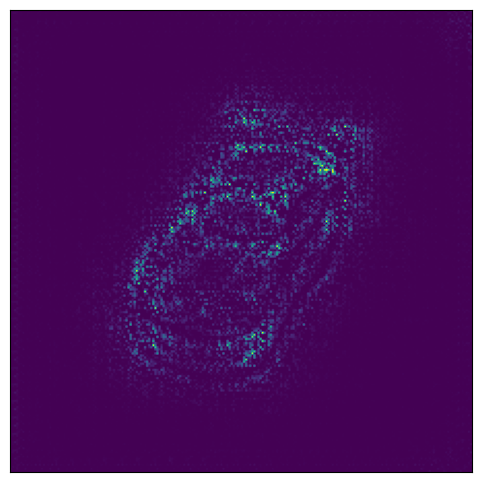

In [ ]:
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)), method="heat_map", sign="positive", cmap="viridis")

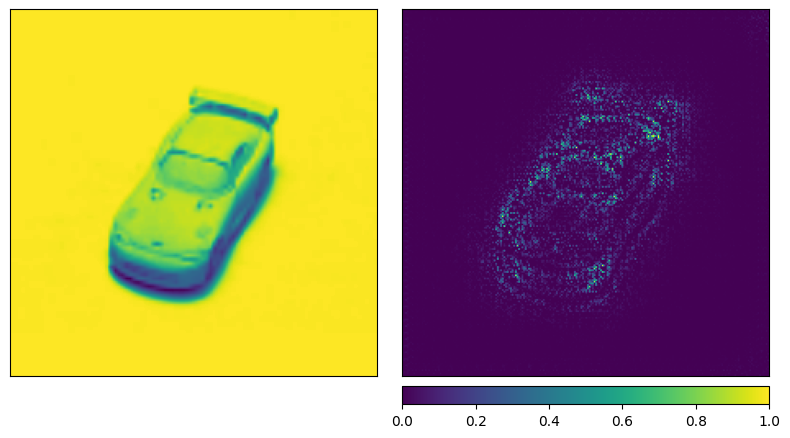

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)),
                             np.transpose(sample.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap="viridis",
                             show_colorbar=True)

(-0.5, 223.5, 223.5, -0.5)

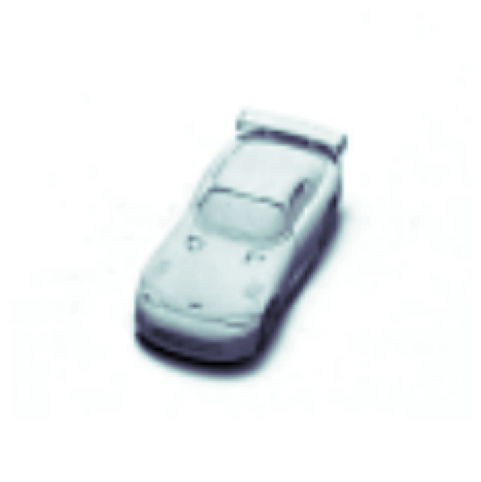

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(sample.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)), cmap="bone")
plt.axis("off")

In [ ]:
img1 = Image.open("/content/drive/MyDrive/TTA/smallnorbVGGimage.png")
img2 = Image.open("/content/drive/MyDrive/TTA/smallnorbConvNeXTfeatures.png")

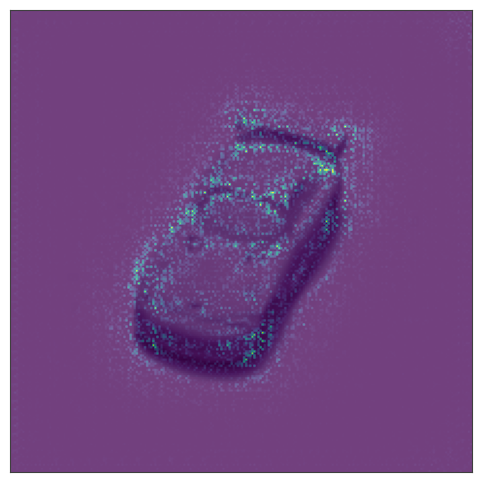

In [ ]:
Image.blend(im1=img1, im2=img2, alpha=0.75)

## ConvNextV2

In [ ]:
from transformers import ConvNextV2ForImageClassification, ConvNextV2Config

class CustomConvNextV2Model(ConvNextV2ForImageClassification):
    def __init__(self, config, *args, **kwargs):
        super(CustomConvNextV2Model, self).__init__(config, *args, **kwargs)

    def forward(self, *args, **kwargs):
        # Call the original forward method
        outputs = super(CustomConvNextV2Model, self).forward(*args, **kwargs)

        # Extract the logits tensor from the output
        logits_tensor = outputs.logits

        return logits_tensor

# Load the pre-trained model
config = ConvNextV2Config.from_pretrained("facebook/convnextv2-base-1k-224")
convnextv2_model = CustomConvNextV2Model.from_pretrained("facebook/convnextv2-base-1k-224", config=config)

# 1-channel inputs
convnextv2_model.convnextv2.embeddings.patch_embeddings = nn.Conv2d(IN_CHANNELS, 128, kernel_size=(4,4), stride=(4,4))
convnextv2_model.convnextv2.embeddings.num_channels = IN_CHANNELS

# Add on classifier
n_inputs = convnextv2_model.classifier.in_features
convnextv2_model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.GELU(), nn.Dropout(0.4),
    nn.Linear(256, N_CLASSES), nn.Softmax(dim=1))

convnextv2_model.load_state_dict(torch.load("/content/drive/MyDrive/TTA/convnextv2-smallnorb.pt"))

<All keys matched successfully>

In [ ]:
sample = test_ds.__getitem__(429)[0]
print(test_ds.__getitem__(429)[1])
sample = sample.unsqueeze(0)

4


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
sample = sample.to(device)

In [ ]:
convnextv2_model = convnextv2_model.to(device)
convnextv2_model.eval()

output = convnextv2_model(sample)

In [ ]:
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
print(prediction_score.squeeze().item(), pred_label_idx.item())

0.4046096205711365 4


In [ ]:
# Create IntegratedGradients object and get attributes
integrated_gradients = IntegratedGradients(convnextv2_model)
attributions_ig = integrated_gradients.attribute(sample, target=pred_label_idx.item(), n_steps=30)

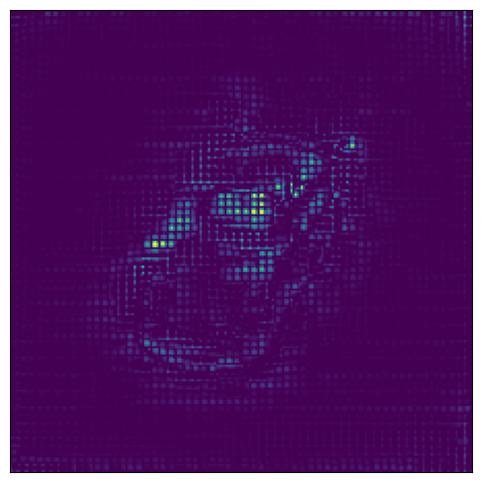

In [ ]:
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)), method="heat_map", sign="positive", cmap="viridis")

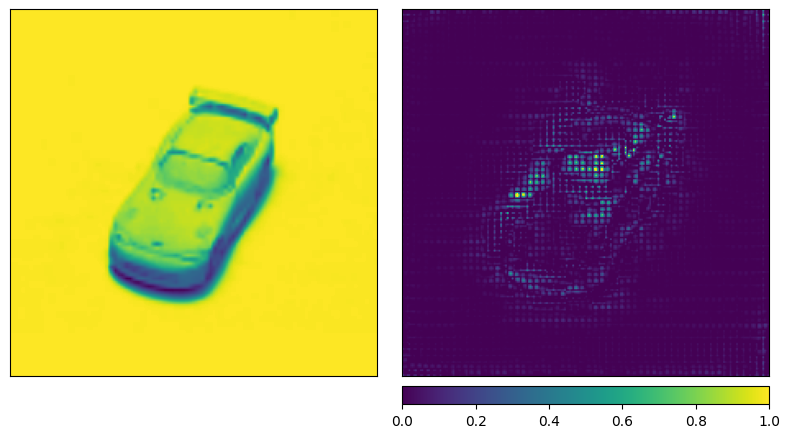

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)),
                             np.transpose(sample.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap="viridis",
                             show_colorbar=True)

(-0.5, 223.5, 223.5, -0.5)

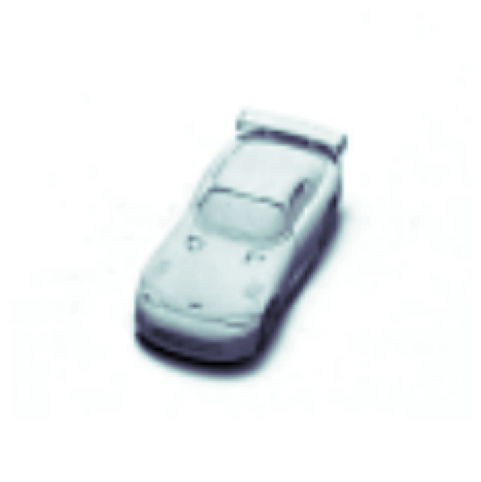

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(sample.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)), cmap="bone")
plt.axis("off")

In [ ]:
from PIL import Image

In [ ]:
img1 = Image.open("/content/drive/MyDrive/TTA/smallnorbVGGimage.png")
img2 = Image.open("/content/drive/MyDrive/TTA/smallnorbConvNeXTV2features.png")

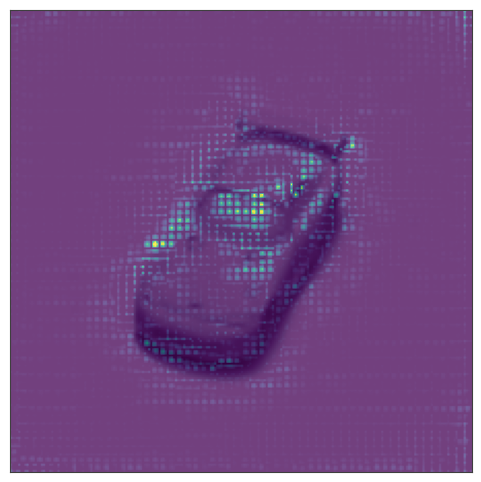

In [ ]:
Image.blend(im1=img1, im2=img2, alpha=0.75)

## iResNet50

In [37]:
# Load the pre-trained model
IN_CHANNELS = 1
N_CLASSES = 5

resnet50_model = tv.models.resnet50(weights="IMAGENET1K_V1")

for param in resnet50_model.parameters():
    param.requires_grad = False

# 1-channel inputs
resnet50_model.conv1 = nn.Conv2d(IN_CHANNELS, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

# Add on classifier
n_inputs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.6),
    nn.Linear(256, N_CLASSES), nn.LogSoftmax(dim=1))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.3MB/s]


In [38]:
resnet50_model.load_state_dict(torch.load("/content/drive/MyDrive/UM_Project/checkpoints/resnet50-smallnorb.pt"))

<All keys matched successfully>

In [39]:
!nvidia-smi

Thu Jan  4 19:51:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0              30W /  70W |   1405MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [40]:
sample = test_ds.__getitem__(429)[0]
print(test_ds.__getitem__(429)[1])
sample = sample.unsqueeze(0)

4


In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sample = sample.to(device)

In [42]:
resnet50_model = resnet50_model.to(device)
resnet50_model.eval()

output = resnet50_model(sample)
print(output)

tensor([[-8.1133, -7.8244, -6.8905, -3.6042, -0.0294]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)


In [43]:
!nvidia-smi

Thu Jan  4 19:51:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0              30W /  70W |   1571MiB / 15360MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [44]:
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
print(prediction_score.squeeze().item(), pred_label_idx.item())

0.9710728526115417 4


In [45]:
# Create IntegratedGradients object and get attributes
integrated_gradients = IntegratedGradients(resnet50_model)
attributions_ig = integrated_gradients.attribute(sample, target=pred_label_idx.item(), n_steps=30)

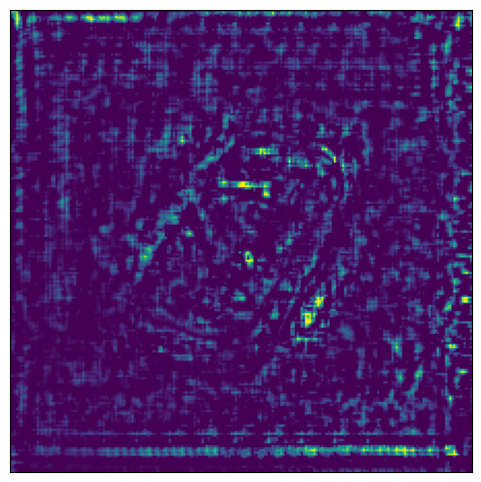

In [46]:
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)), method="heat_map", sign="positive", cmap="viridis")

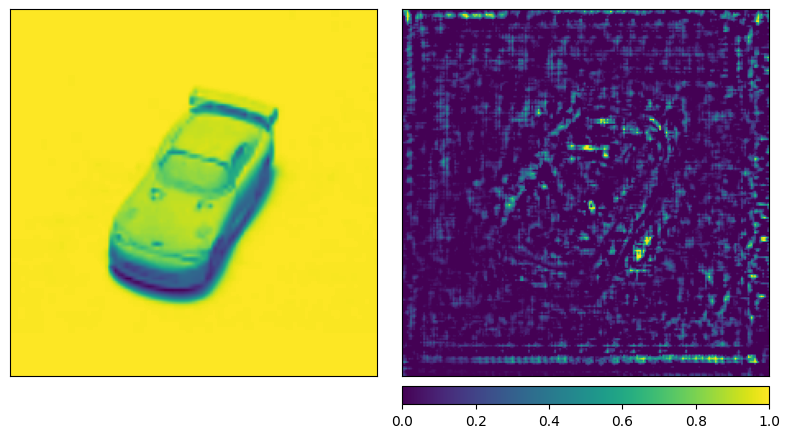

In [47]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)),
                             np.transpose(sample.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap="viridis",
                             show_colorbar=True)

(-0.5, 223.5, 223.5, -0.5)

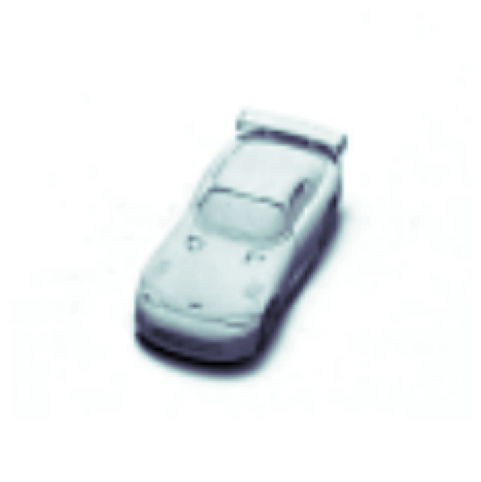

In [48]:
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(sample.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)), cmap="bone")
plt.axis("off")

In [ ]:
from PIL import Image

In [49]:
img1 = Image.open("/content/drive/MyDrive/UM_Project/images/image-r50.png")
img2 = Image.open("/content/drive/MyDrive/UM_Project/images/cmap-r50.png")

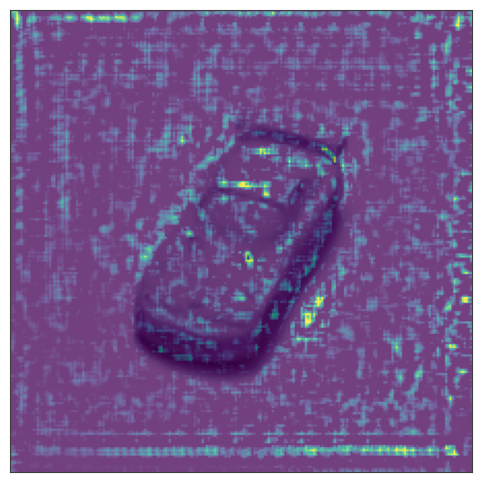

In [50]:
Image.blend(im1=img1, im2=img2, alpha=0.75)

## SWIN

In [51]:
# Load the pre-trained model
IN_CHANNELS = 1
N_CLASSES = 5

swin_model = tv.models.swin_b(weights="IMAGENET1K_V1")

for param in swin_model.parameters():
    param.requires_grad = False

# 1-channel inputs
swin_model.features[0][0] = nn.Conv2d(IN_CHANNELS, 128, kernel_size=(4,4), stride=(4,4))

# Add on classifier
n_inputs = swin_model.head.in_features
swin_model.head = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.GELU(), nn.Dropout(0.6),
    nn.Linear(256, N_CLASSES), nn.LogSoftmax(dim=1))

In [52]:
swin_model.load_state_dict(torch.load("/content/drive/MyDrive/UM_Project/checkpoints/swin-smallnorb.pt"))

<All keys matched successfully>

In [53]:
!nvidia-smi

Thu Jan  4 19:54:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0              32W /  70W |   3823MiB / 15360MiB |     17%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [54]:
sample = test_ds.__getitem__(429)[0]
print(test_ds.__getitem__(429)[1])
sample = sample.unsqueeze(0)

4


In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sample = sample.to(device)

In [56]:
swin_model = swin_model.to(device)
swin_model.eval()

output = swin_model(sample)
print(output)

tensor([[-6.9722, -7.4397, -6.0992, -3.3872, -0.0383]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)


In [57]:
!nvidia-smi

Thu Jan  4 19:54:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0              32W /  70W |   3857MiB / 15360MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [58]:
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
print(prediction_score.squeeze().item(), pred_label_idx.item())

0.9624264240264893 4


In [59]:
# Create IntegratedGradients object and get attributes
integrated_gradients = IntegratedGradients(swin_model)
attributions_ig = integrated_gradients.attribute(sample, target=pred_label_idx.item(), n_steps=30)

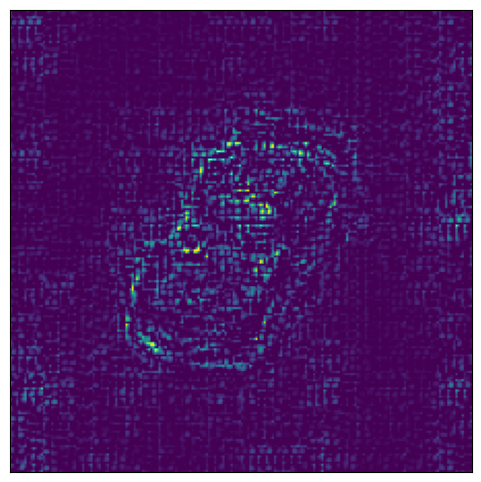

In [60]:
_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)), method="heat_map", sign="positive", cmap="viridis")

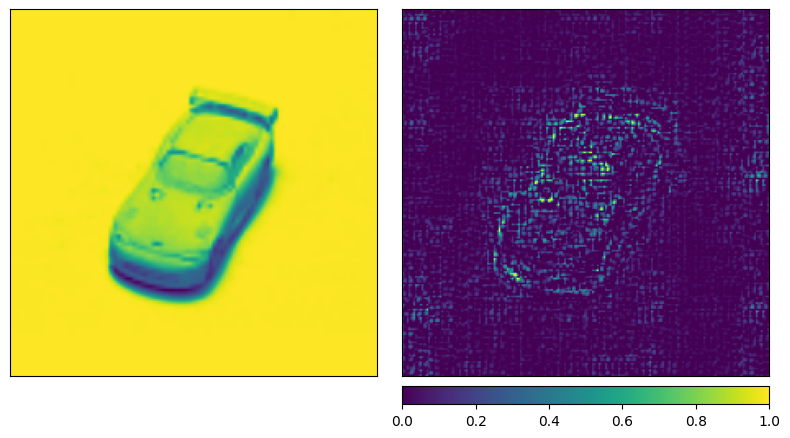

In [61]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)),
                             np.transpose(sample.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap="viridis",
                             show_colorbar=True)

(-0.5, 223.5, 223.5, -0.5)

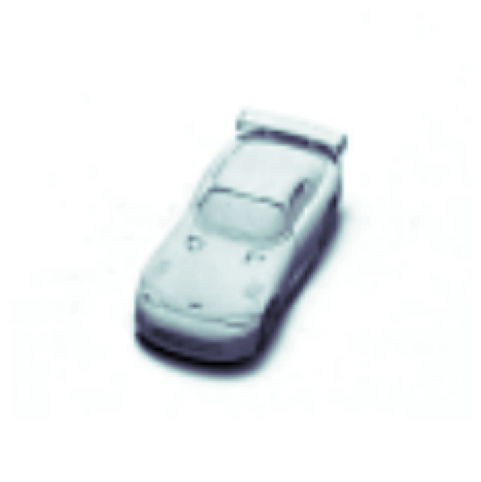

In [62]:
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(sample.squeeze(dim=0).cpu().detach().numpy(), (1,2,0)), cmap="bone")
plt.axis("off")

In [63]:
from PIL import Image

In [66]:
img1 = Image.open("/content/drive/MyDrive/UM_Project/images/image-swin.png")
img2 = Image.open("/content/drive/MyDrive/UM_Project/images/cmap-swin.png")

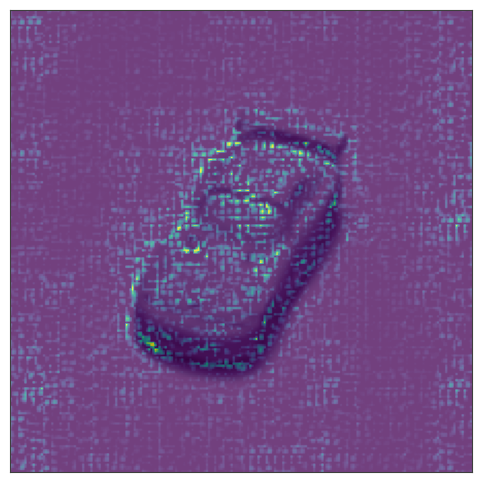

In [67]:
Image.blend(im1=img1, im2=img2, alpha=0.75)